In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import xarray as xr
import intake
from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import merge_variables, pick_first_member
import warnings

warnings.filterwarnings("ignore", category=xr.SerializationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

mpl.rcParams["figure.figsize"] = 6, 4
mpl.rcParams["font.size"] = 12

### Open Pangeo CMIP6 data catalogue

This points to where the Pangeo organization has uploaded CMIP6 data to Google Cloud storage, and provides a searchable database of what is available

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)

### Search catalogue for experiments and variables we want

Search for sea ice concentration and grid cell area for historical runs.  
`require_all_on="source_id"` makes sure that the given model (`source_id`) has all the other parameters (in this case most importantly both variables) available.

In [4]:
cat = col.search(
    experiment_id="historical", 
    variable_id=['siconc', "areacello"],
    grid_label='gn',
    require_all_on="source_id"
)
cat.df.head()

/Users/pauan78p/miniconda3/envs/cmip6_seaice_pangeo/lib/python3.11/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191108
1,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r2i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20191125
2,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r3i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20200306
3,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r2i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20200817
4,CMIP,CSIRO-ARCCSS,ACCESS-CM2,historical,r1i1p1f1,SImon,siconc,gn,gs://cmip6/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/...,NaN,20200817


### Load the data into a dictionary

Load the data using the intake-esm function  
`xarray_open_kwargs` are arguments to go to the backend for the data. In this case `consolidated=True` makes sure the data, which is stored in lots of chunks in zarr format, are loaded as consolidated files for a given variable

`preprocess=combined_preprocessing` uses the function from the xMIP package to preprocess the CMIP6 data to make sure all the dimension and coordinate names are consistent across models so that we can easily work with them later

`aggregate=False` prevents intake-esm from trying to aggregate the data across ensemble members as this caused some errors, and we'll do it ourselves shortly

`skip_on_error=True` makes sure that the loading continues if there's an issue loading a variable, so that it doesn't crash the whole thing 

In [5]:
dset_dict = cat.to_dataset_dict(
    xarray_open_kwargs={'consolidated': True}, 
    preprocess=combined_preprocessing, 
    aggregate=False,
    skip_on_error=True
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.member_id.table_id.variable_id.grid_label.zstore.dcpp_init_year.version'


### Pick one ensemble member for each model

Use the xMIP function `pick_first_member` to grab one ensemble member from each model for now, just to speed things up. Easy to remove later

In [6]:
dset_dict_onemember = pick_first_member(dset_dict)

### Get the names of the models that we grabbed

In [7]:
keys = list(dset_dict_onemember.keys())

valid_models = [key.split(".")[0] for key in keys]
valid_models = sorted(list(set(valid_models)))
valid_models

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'CAS-ESM2-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM-FV2',
 'CIESM',
 'CMCC-CM2-HR4',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'CanESM5-CanOE',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'EC-Earth3-Veg-LR',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'FIO-ESM-2-0',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'IPSL-CM6A-LR-INCA',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1']

### Compute Antarctic sea ice area for each model

In [8]:
siarea_dict = {}

for model in valid_models:
    print(model)
    
    try:
        sikey = [key for key in keys if model in key and "SImon" in key][0]
        okey = [key for key in keys if model in key and "Ofx" in key][0]
    except IndexError:
        continue
 
    siconc = dset_dict_onemember[sikey]["siconc"].squeeze()
    area = dset_dict_onemember[okey]["areacello"].squeeze()

    siarea = (siconc*area).isel(y=slice(None, int(area.y.size/2)))
    siarea = siarea.sum(("x", "y")).compute()/1e14
    
    siarea_dict[model] = siarea

ACCESS-CM2
ACCESS-ESM1-5
CAS-ESM2-0
CESM2
CESM2-FV2
CESM2-WACCM-FV2
CIESM
CMCC-CM2-HR4
CMCC-CM2-SR5
CMCC-ESM2
CNRM-CM6-1
CNRM-CM6-1-HR
CNRM-ESM2-1
CanESM5
CanESM5-CanOE
EC-Earth3
EC-Earth3-AerChem
EC-Earth3-CC
EC-Earth3-Veg
EC-Earth3-Veg-LR
FGOALS-f3-L
FGOALS-g3
FIO-ESM-2-0
GFDL-CM4
GFDL-ESM4
IPSL-CM5A2-INCA
IPSL-CM6A-LR
IPSL-CM6A-LR-INCA
MIROC-ES2L
MIROC6
MPI-ESM-1-2-HAM
MPI-ESM1-2-HR
MPI-ESM1-2-LR
MRI-ESM2-0
NorCPM1
NorESM2-LM
NorESM2-MM
SAM0-UNICON
TaiESM1


### Compute the annual average

In [9]:
for model in siarea_dict.keys():
    siarea_dict[model] = siarea_dict[model].groupby("time.year").mean("time")

### Make plot of annual-mean Antarctic sea ice area

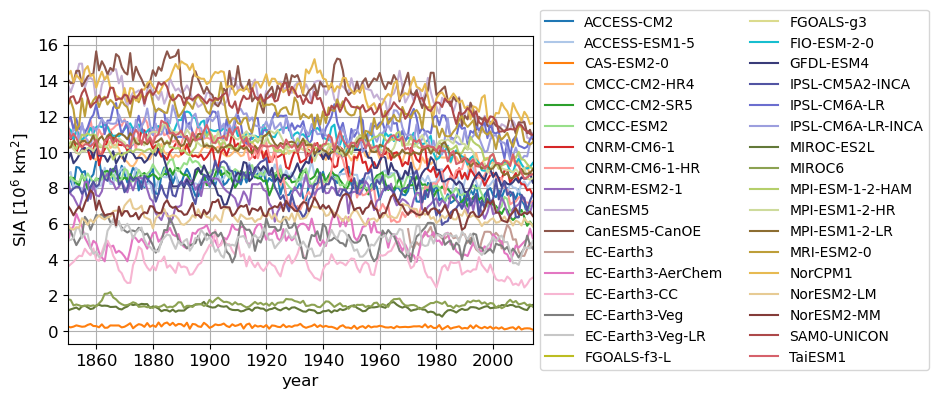

In [10]:
colors = pl.cm.tab20.colors + pl.cm.tab20b.colors

fig = plt.figure(1)
for n, model in enumerate(siarea_dict.keys()):
    if model not in ["GFDL-CM4"]:
        siarea_dict[model].plot.line(x="year", label=model, color=colors[n])
    
plt.legend(loc="center left", bbox_to_anchor=[1.0, 0.5], ncol=2, fontsize=10)
plt.title("")
plt.ylabel("SIA [10$^6$ km$^2$]")
plt.grid()
plt.xlim(1850, 2014)

fig.savefig("../figures/cmip6_sia.png",
            bbox_inches="tight", dpi=300)

### Make plot of annual-mean Antarctic sea ice area anomaly from 1850-1900 average

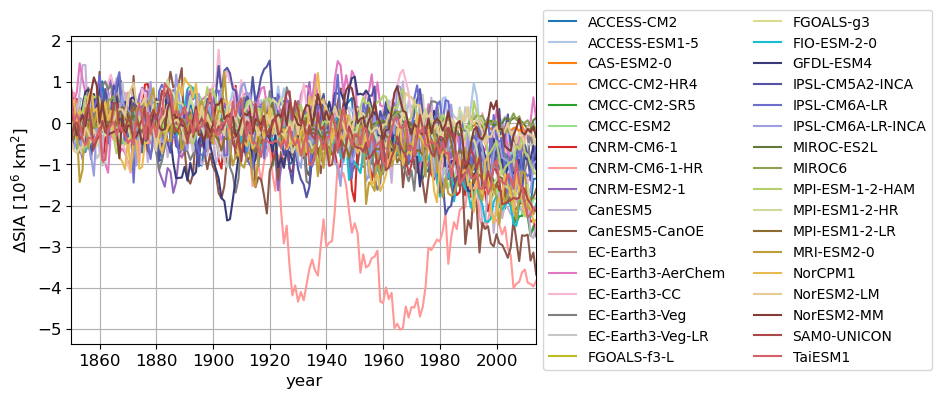

In [11]:
fig = plt.figure(1)
for n, model in enumerate(siarea_dict.keys()):
    climo = siarea_dict[model].sel(year=slice(1850, 1900)).mean("year")
    anom = siarea_dict[model] - climo
    
    if model not in ["GFDL-CM4"]:
        anom.plot.line(x="year", label=model, color=colors[n])
        
plt.legend(loc="center left", bbox_to_anchor=[1.0, 0.5], ncol=2, fontsize=10)
plt.title("")
plt.ylabel("$\Delta$SIA [10$^6$ km$^2$]")
plt.grid()
plt.xlim(1850, 2014)

fig.savefig("../figures/cmip6_sia_anomaly_1850-1900.png",
            bbox_inches="tight", dpi=300)